# Dockless Scooter Data

In [46]:
import matplotlib, shapely, geopandas
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time, datetime
from sklearn.linear_model import LinearRegression

In [2]:
tract_to_name = {
    '000204': "Triangle",
    '000500': "North Campus",
    '000700': "South Campus",
    '000401': "East Campus",
    '000604': "Lower West Campus",
    '000603': "Upper West Campus",
    '000601': "Campus"
}

tract_to_index = {
    '000204': 0,
    '000500': 1,
    '000700': 2,
    '000401': 3,
    '000604': 4,
    '000603': 5,
    '000601': 6,
}

In [3]:
scooter_data = pd.read_csv('~/work/data/Dockless_Vehicle_Trips.csv')
austin_data = austin = geopandas.GeoDataFrame.from_file('/home/jovyan/work/data/census_tracts_2010_msa/census_tracts_2010_msa.shp',)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Dropping the first 6 digits of the tract start and end ids and converting to a numerical type.

In [4]:
scooter_data = scooter_data.dropna(subset=['Census Tract Start'])
                                   
scooter_data.sample(5)

,ID,Device ID,Vehicle Type,Trip Duration,Trip Distance,Start Time,End Time,Modified Date,Month,Hour,Day of Week,Council District (Start),Council District (End),Year,Census Tract Start,Census Tract End
1461119,42582337-3470-4c63-af04-71bb06f4450e,76dca3d1-b363-43e3-88e7-2b017f4f8ad7,scooter,197.0,378.0,08/24/2018 09:00:00 AM,08/24/2018 09:00:00 AM,04/17/2019 02:00:17 AM,8.0,9.0,5.0,9.0,9.0,2018.0,48453001100,48453001100
791953,52a6cad4-72bc-452a-83b3-e6b86c3f1e70,95839ddd-88c1-41db-89ae-2f52dd55d91e,scooter,1939.0,2626.0,10/22/2018 05:15:00 PM,10/22/2018 05:45:00 PM,04/17/2019 04:19:40 AM,10.0,17.0,1.0,9.0,9.0,2018.0,48453001100,48453001100
3198630,518791fd-5719-49cb-b3d0-98a2d5e9ad8c,9ac4e8a9-df15-4677-a601-3e553fe4fd2d,scooter,447.0,1148.0,12/19/2018 01:15:00 PM,12/19/2018 01:30:00 PM,04/17/2019 05:34:34 AM,12.0,13.0,3.0,1.0,9.0,2018.0,48453000401,48453000601
1827125,881f25b1-69ac-46b6-a1b0-1516cf480501,30006609-6080-4456-88cd-fab12285072d,scooter,316.0,1005.0,11/29/2018 06:30:00 PM,11/29/2018 06:45:00 PM,04/17/2019 01:39:32 AM,11.0,18.0,4.0,9.0,9.0,2018.0,48453000604,48453000601
4038650,344f2e4e-e527-4c5f-a4d6-b28b296ca337,bf7a4b37-7b94-4091-95f1-8ca628a8ec2c,scooter,245.0,734.0,11/08/2018 08:30:00 AM,11/08/2018 08:30:00 AM,04/17/2019 05:49:17 PM,11.0,8.0,4.0,9.0,9.0,2018.0,48453001200,48453001200


In [5]:
scooter_data = scooter_data[scooter_data['Census Tract Start'] != 'OUT_OF_BOUNDS']
scooter_data = scooter_data[scooter_data['Census Tract End'] != 'OUT_OF_BOUNDS']
scooter_data['Census Tract Start'] = pd.to_numeric(scooter_data['Census Tract Start'])
scooter_data['Census Tract End'] = pd.to_numeric(scooter_data['Census Tract End'])

In [6]:
def tract_to_trunk(tract):
    return "%06d" % (int(tract) % 1000000)

scooter_data['tract_start'] = scooter_data['Census Tract Start'].apply(tract_to_trunk)
scooter_data['tract_end'] = scooter_data['Census Tract End'].apply(tract_to_trunk)

In [7]:
oncampus  = ['000601']
offcampus = ['000204', '000500', '000700', '000401', '000604', '000603']
scooter_data_starting = scooter_data[scooter_data['tract_start'].isin(oncampus + offcampus)]
scooter_data_ending   = scooter_data[scooter_data['tract_end'].isin(oncampus + offcampus)]

In [8]:
scooter_data_raw = pd.read_csv('~/work/data/Dockless_Vehicle_Trips.csv')
scooter_data_raw.shape

(4561813, 16)

In [9]:
100 * (scooter_data_starting.shape[0] / scooter_data_raw.shape[0])

31.847052915145795

In [10]:
start_freqs = scooter_data_starting.groupby(['tract_start'])['tract_start'].agg('count').to_frame('count').reset_index()
start_data = geopandas.GeoDataFrame(pd.merge(start_freqs, austin_data, how='inner', left_on=['tract_start'], right_on=['TRACTCE10']))
start_data.head()

,tract_start,count,TRACTCE10,SUM_totpop,SUM_white,SUM_black,SUM_hispan,SUM_asian,SUM_other,SUM_multi,...,SUM_AGE651,SUM_AGE_65,SUM_AGE75_,SUM_AGE80_,SUM_AGE_85,SUM_FAMSWC,SUM_POP_IN,SUM_FAMILI,SUM_NONFAM,geometry
0,000204,24339,000204,3009.0,2396.0,43.0,323.0,161.0,8.0,78.0,...,21.0,80.0,27.0,20.0,26.0,234.0,56.0,495.0,1101.0,"POLYGON ((3114760.420262146 10081981.02697965,..."
1,000401,111638,000401,3574.0,2446.0,128.0,445.0,439.0,14.0,102.0,...,26.0,86.0,24.0,19.0,19.0,159.0,195.0,442.0,1288.0,"POLYGON ((3119875.384202184 10081103.12966995,..."
2,000500,43637,000500,4518.0,3305.0,67.0,545.0,464.0,18.0,119.0,...,37.0,101.0,13.0,11.0,15.0,147.0,77.0,430.0,2110.0,"POLYGON ((3117812.349419988 10078757.10780583,..."
3,000601,506146,000601,9207.0,4491.0,494.0,1972.0,1943.0,12.0,295.0,...,1.0,2.0,0.0,0.0,0.0,11.0,8396.0,44.0,389.0,"POLYGON ((3116530.436981633 10075208.93904213,..."
4,000603,342530,000603,7793.0,5121.0,149.0,972.0,1351.0,22.0,178.0,...,5.0,14.0,2.0,0.0,1.0,17.0,821.0,209.0,3027.0,"POLYGON ((3114630.355919199 10079462.03781622,..."


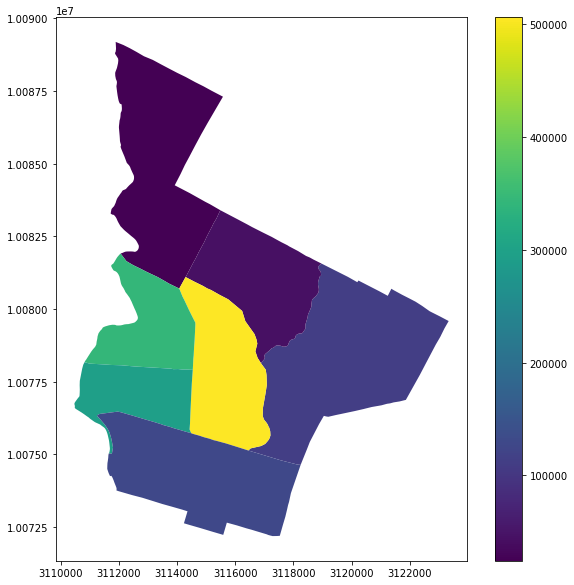

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
start_data.plot(column='count', ax=ax, legend=True)

In [12]:
end_freqs = scooter_data_ending.groupby(['tract_end'])['tract_end'].agg('count').to_frame('count').reset_index()
end_data = geopandas.GeoDataFrame(pd.merge(end_freqs, austin_data, how='inner', left_on=['tract_end'], right_on=['TRACTCE10']))
end_data.head()

,tract_end,count,TRACTCE10,SUM_totpop,SUM_white,SUM_black,SUM_hispan,SUM_asian,SUM_other,SUM_multi,...,SUM_AGE651,SUM_AGE_65,SUM_AGE75_,SUM_AGE80_,SUM_AGE_85,SUM_FAMSWC,SUM_POP_IN,SUM_FAMILI,SUM_NONFAM,geometry
0,000204,25858,000204,3009.0,2396.0,43.0,323.0,161.0,8.0,78.0,...,21.0,80.0,27.0,20.0,26.0,234.0,56.0,495.0,1101.0,"POLYGON ((3114760.420262146 10081981.02697965,..."
1,000401,119443,000401,3574.0,2446.0,128.0,445.0,439.0,14.0,102.0,...,26.0,86.0,24.0,19.0,19.0,159.0,195.0,442.0,1288.0,"POLYGON ((3119875.384202184 10081103.12966995,..."
2,000500,45669,000500,4518.0,3305.0,67.0,545.0,464.0,18.0,119.0,...,37.0,101.0,13.0,11.0,15.0,147.0,77.0,430.0,2110.0,"POLYGON ((3117812.349419988 10078757.10780583,..."
3,000601,547597,000601,9207.0,4491.0,494.0,1972.0,1943.0,12.0,295.0,...,1.0,2.0,0.0,0.0,0.0,11.0,8396.0,44.0,389.0,"POLYGON ((3116530.436981633 10075208.93904213,..."
4,000603,306894,000603,7793.0,5121.0,149.0,972.0,1351.0,22.0,178.0,...,5.0,14.0,2.0,0.0,1.0,17.0,821.0,209.0,3027.0,"POLYGON ((3114630.355919199 10079462.03781622,..."


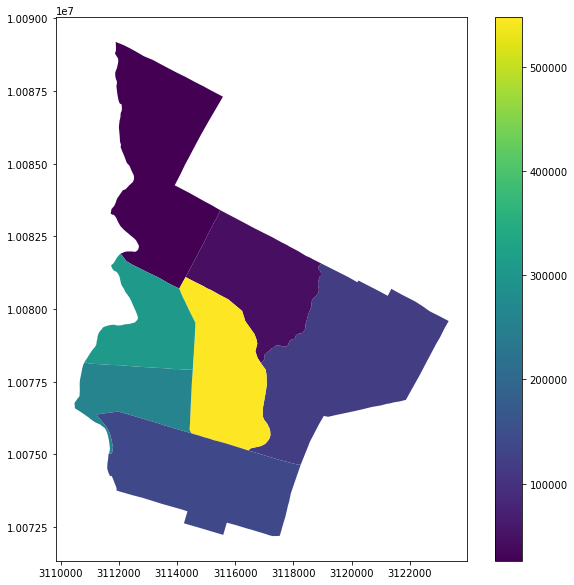

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
end_data.plot(column='count', ax=ax, legend=True)

In [14]:
print(scooter_data_starting.shape, scooter_data_ending.shape)
scooter_data_starting.head()
merged_data =scooter_data_starting[scooter_data_starting['ID'].isin(scooter_data_ending['ID'])]
merged_data.shape

(1452803, 18) (1446243, 18)


(1327537, 18)

In [15]:
merged_start_freqs = merged_data.groupby(['tract_start'])['tract_start'].agg('count').to_frame('count').reset_index()
merged_end_freqs = merged_data.groupby(['tract_end'])['tract_end'].agg('count').to_frame('count').reset_index()

merged_start_data = geopandas.GeoDataFrame(pd.merge(merged_start_freqs, austin_data, how='inner', left_on=['tract_start'], right_on=['TRACTCE10']))
merged_end_data = geopandas.GeoDataFrame(pd.merge(merged_end_freqs, austin_data, how='inner', left_on=['tract_end'], right_on=['TRACTCE10']))

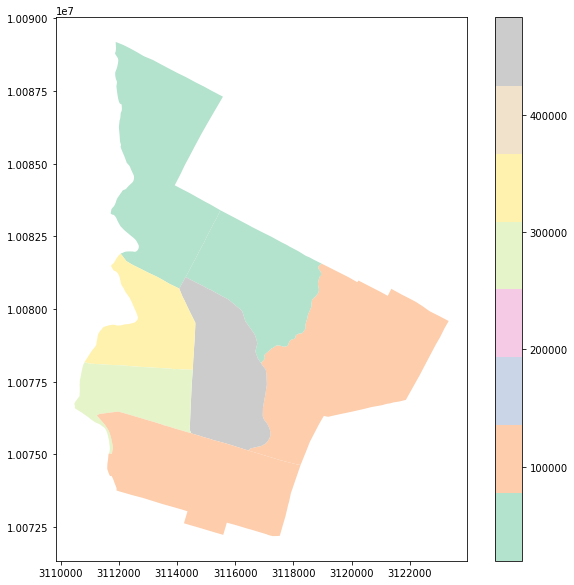

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
merged_start_data.plot(column='count', ax=ax, legend=True, cmap='Pastel2')

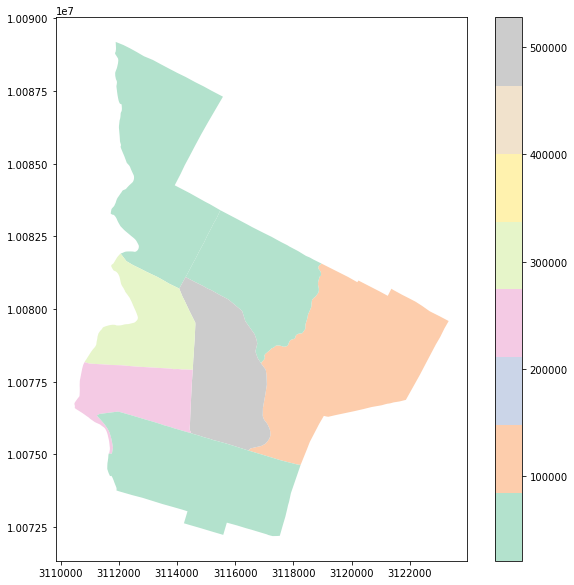

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
merged_end_data.plot(column='count', ax=ax, legend=True, cmap='Pastel2')

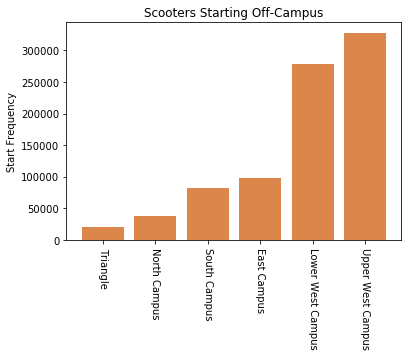

In [18]:
total = 0
d = []
d_norm = []
labels = []
for loc in offcampus:
    freq = merged_start_freqs[merged_start_freqs["tract_start"] == loc]["count"].iloc[0]
    total += freq
    labels.append(tract_to_name[str(loc)])
    d.append(freq)

for loc in offcampus:
    freq = merged_start_freqs[merged_start_freqs["tract_start"] == loc]["count"].iloc[0]
    d_norm.append(freq / total)

plt.bar(labels, d, align='center', color='#cc5500', alpha=0.7)
plt.ylabel('Start Frequency')
plt.xticks(rotation=-90)
plt.title('Scooters Starting Off-Campus')

plt.show()

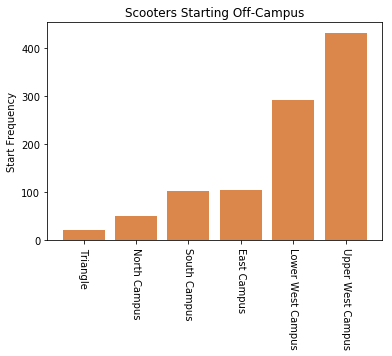

In [19]:
# randomly sample a location :-)
freqqq = [0]*len(offcampus)
for _ in range(1000):
    freqqq[tract_to_index[np.random.choice(offcampus, p=d_norm)]] += 1

plt.bar(labels, freqqq, align='center', color='#cc5500', alpha=0.7)
plt.ylabel('Start Frequency')
plt.xticks(rotation=-90)
plt.title('Scooters Starting Off-Campus')

plt.show()

    Hour  count
14  14.0  10587
16  16.0  10238
15  15.0  10230
    Hour  count
12  12.0  17467
13  13.0  16119
14  14.0  15501
    Hour  count
12  12.0  21069
15  15.0  18788
9    9.0  17597
    Hour  count
12  12.0  19046
13  13.0  17778
14  14.0  17001
    Hour  count
12  12.0  22433
15  15.0  19431
9    9.0  18762
    Hour  count
12  12.0  18290
13  13.0  17581
11  11.0  16597
    Hour  count
16  16.0  14656
15  15.0  14553
14  14.0  14009


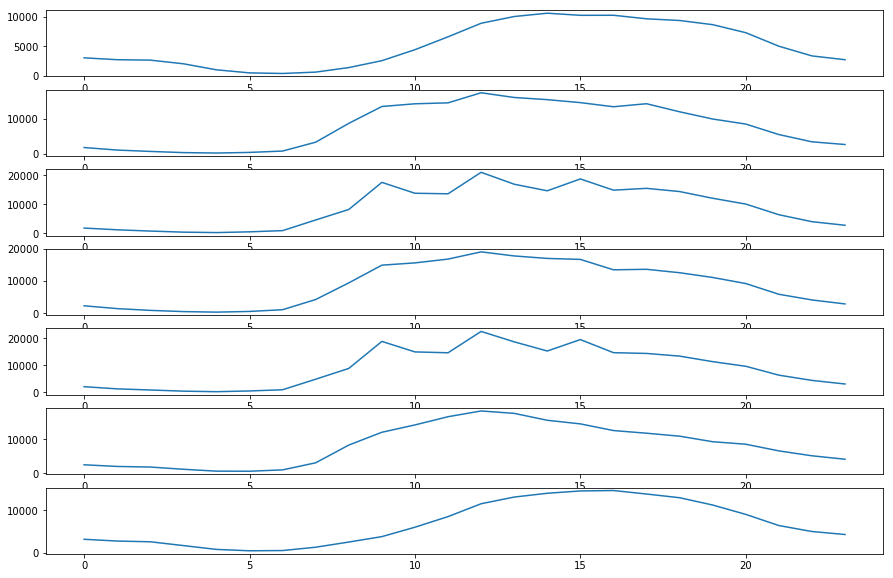

In [20]:
fig, ax = plt.subplots(7, 1,figsize=(15, 10))
for i in range(7): # 0 = sunday, 6 = saturday
    time_freq = merged_data[merged_data['Day of Week'] == i].groupby(['Hour'])['Hour'].agg('count').to_frame('count').reset_index()
    ax[i].plot(time_freq['Hour'], time_freq['count'])
    print(time_freq.nlargest(3, "count"))

In [21]:
merged_data['Start Time'] = pd.to_datetime(merged_data['Start Time'], format="%m/%d/%Y %I:%M:%S %p")
merged_data['End Time']   = pd.to_datetime(merged_data['End Time'],   format="%m/%d/%Y %I:%M:%S %p")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
merged_data['Start Time'].sample()

4264207   2018-12-16 20:15:00
Name: Start Time, dtype: datetime64[ns]

In [23]:
def to_decimal(strtime):
    hour, minute = map(int, strtime.strftime("%H:%M").split(':'))
    return hour + (minute / 60)

merged_data['start_hour_decimal'] = merged_data['Start Time'].apply(to_decimal)
merged_data['end_hour_decimal'] = merged_data['End Time'].apply(to_decimal)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
merged_data.head()

,ID,Device ID,Vehicle Type,Trip Duration,Trip Distance,Start Time,End Time,Modified Date,Month,Hour,Day of Week,Council District (Start),Council District (End),Year,Census Tract Start,Census Tract End,tract_start,tract_end,start_hour_decimal,end_hour_decimal
2,aa27d854-9f27-456e-ae49-f268a9b2b533,6b90a827-60a1-47ad-94a4-d33654dbd50d,scooter,170.0,0.0,2019-04-29 17:30:00,2019-04-29 17:30:00,04/30/2019 06:45:17 AM,4.0,17.0,1.0,9.0,9.0,2019.0,4.845300e+10,4.845300e+10,000601,000601,17.5,17.50
3,b7c9f133-966b-46f1-91ce-2682ce7fcf50,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,90.0,0.0,2019-04-29 17:30:00,2019-04-29 17:30:00,04/30/2019 06:45:17 AM,4.0,17.0,1.0,9.0,9.0,2019.0,4.845300e+10,4.845300e+10,000601,000601,17.5,17.50
5,cd442fb9-058f-46a7-af90-b4adb56fd163,1653cf10-75f5-4934-a9d9-c8d43ade67a9,scooter,438.0,1815.0,2019-04-29 17:30:00,2019-04-29 17:45:00,04/30/2019 06:45:17 AM,4.0,17.0,1.0,9.0,9.0,2019.0,4.845300e+10,4.845300e+10,000601,000500,17.5,17.75
7,b7df9ed5-61ae-40ca-9b7e-0ffa1d092b79,09b2c7b8-6631-4999-85d5-4273b4c98f3a,scooter,153.0,0.0,2019-04-29 17:00:00,2019-04-29 17:00:00,04/30/2019 06:45:17 AM,4.0,17.0,1.0,9.0,9.0,2019.0,4.845300e+10,4.845300e+10,000604,000604,17.0,17.00
11,7211c488-c0ad-40a9-8a07-4326dbb56c6f,9e6ae0d2-76a0-4e24-8f6e-8d724564b638,scooter,432.0,1698.0,2019-04-29 17:30:00,2019-04-29 17:30:00,04/30/2019 06:45:17 AM,4.0,17.0,1.0,9.0,9.0,2019.0,4.845300e+10,4.845300e+10,000601,000603,17.5,17.50


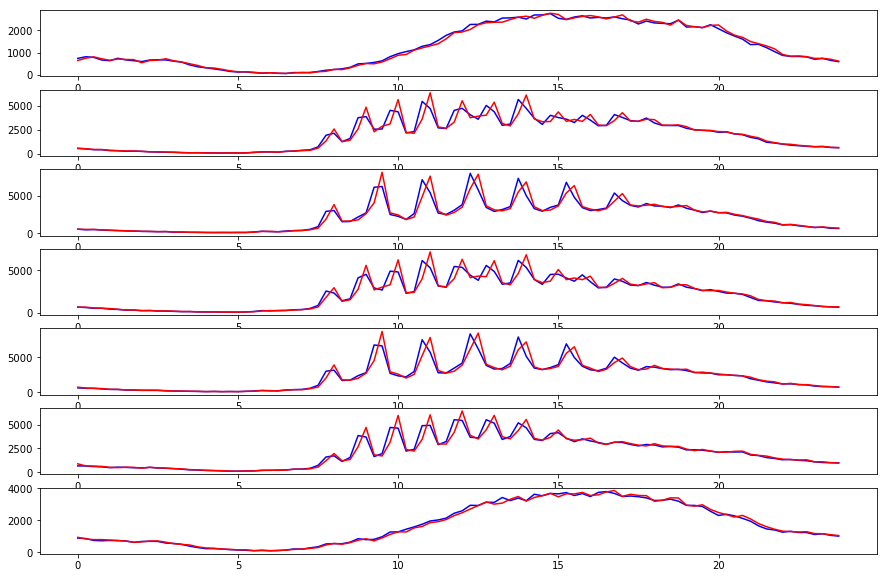

In [25]:
fig, ax = plt.subplots(7, 1,figsize=(15, 10))
for i in range(7): # 0 = sunday, 6 = saturday
    start_time_freq = merged_data[merged_data['Day of Week'] == i].groupby(['start_hour_decimal'])['start_hour_decimal'].agg('count').to_frame('count').reset_index()
    end_time_freq   = merged_data[merged_data['Day of Week'] == i].groupby(['end_hour_decimal'])['end_hour_decimal'].agg('count').to_frame('count').reset_index()
    ax[i].plot(start_time_freq['start_hour_decimal'], start_time_freq['count'], c="blue")
    ax[i].plot(end_time_freq['end_hour_decimal'], end_time_freq['count'], c="red")
#     print(time_freq.nlargest(3, "count"))

In [117]:
def get_start_time_distribution(class_time):
    first_time      = class_time - 0.50
    second_time     = class_time - 0.25
    
    start_time_freq = merged_data[merged_data['Day of Week'] == 3].groupby(['start_hour_decimal'])['start_hour_decimal'].agg('count').to_frame('count').reset_index()
    first  = int(start_time_freq[start_time_freq['start_hour_decimal'] == first_time]['count'].iloc[0])
    second = int(start_time_freq[start_time_freq['start_hour_decimal'] == second_time]['count'].iloc[0])
    third  = int(start_time_freq[start_time_freq['start_hour_decimal'] == class_time]['count'].iloc[0])
    
    first_ln, second_ln, third_ln = np.log(first), np.log(second), np.log(third)
    first_piecewise  = LinearRegression().fit(np.array([0,  15]).reshape((-1, 1)), [first,  second])
    second_piecewise = LinearRegression().fit(np.array([15, 30]).reshape((-1, 1)), [second_ln, third_ln])
    
    distribution = {}
    total = 0.0
    for minute in range(0, 30):
        if minute < 15:
            total += first_piecewise.predict(np.array([minute]).reshape(1, -1))[0]
        else:
            total += np.exp(second_piecewise.predict(np.array([minute]).reshape(1, -1))[0])
            
    for minute in range(0, 30):
        t = first_time + (minute / 60)
        if minute < 15:
            distribution[t] = first_piecewise.predict(np.array([minute]).reshape(1, -1))[0]
        else:
            distribution[t] = np.exp(second_piecewise.predict(np.array([minute]).reshape(1, -1))[0])

        distribution[t] /= total
        
    squished_dist = {first_time: 0.0, second_time: 0.0}
    for minute in range(0, 30):
        t = first_time + (minute / 60)
        if minute < 15:
            squished_dist[first_time] += distribution[t]
        else:
            squished_dist[second_time] += distribution[t]

    return squished_dist

distribution = get_start_time_distribution(8.0)
print(distribution)

distribution = get_start_time_distribution(9.0)
print(distribution)

{7.5: 0.402222758962476, 7.75: 0.5977772410375242}
{8.5: 0.3934300981890413, 8.75: 0.6065699018109585}
